In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# import modules
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# check the version of tf (2.2.0 or higher)
print(tf.__version__)

2.0.0


In [4]:
import sys
import os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

train_dir = "../Flag_Data/test"
valid_dir = "../Flag_Data/val"

In [5]:
# import module for loading & preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Data Augmentation
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

batch_size = 128

# load train dataset
trainGen = imageGenerator.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    subset='training',
    class_mode='categorical'
)

# load val dataset
validationGen = imageGenerator.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    subset='validation',
    class_mode='categorical'
)

Found 182 images belonging to 7 classes.
Found 38 images belonging to 7 classes.


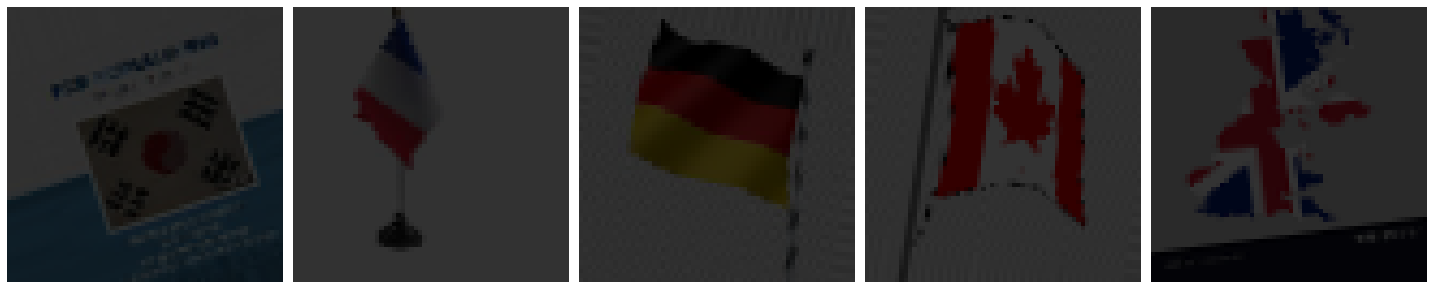

In [7]:
# skip the head of the imported images
sample_training_images, _ = next(trainGen)

# function for displaying images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
 
# plot 5 images to check whether the loading is done correctly   
plotImages(sample_training_images[:5])

In [8]:
# import modules for constructing our neural network
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
import math 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import LearningRateScheduler


In [9]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [10]:
# implementation of inception module

def inception_module(x,
                       filters_1x1,
                       filters_3x3_reduce,
                       filters_3x3,
                       filters_5x5_reduce,
                       filters_5x5,
                       filters_pool_proj,
                       name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output